Original request:

1. Pull and process NTL imagery for all of Yemen, from January 2021 through latest available. 
2. Create 2 line charts, tracking monthly percent change (or other normalized index) of NTL by admin-level 1 (governorate), with markers for the period from 4/2022 to 10/2022, and another chart, with just two lines, for aggregated North (Houthis) and South (IRG) admin-1s. 
3. Prepare a table with the raw data, that the team can use for further analysis and indexing. 

# Yemen Nighttime Lights (NTL) Trends
***
**Author:** <font color='teal'>Andres Chamorro</font>  

The objective of this notebook is to process NTL imagery and aggregate monthly luminosity statistics at the governorate level.

## 1. Data Preparation

### Authenticate Earth Engine Account

NTL imagery will be pulled from data hosted on Google Earth Engine (GEE). Specifically, from this entry: [VIIRS Nighttime Day/Night Band Composites Version 1](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMCFG)  
First, we need to enable access to the Earth Engine API with a valid GEE account.

In [1]:
import ee

If you do not already have an Earth Engine Account, you will need to create one. First, sign up here: (https://earthengine.google.com/signup/) and create a new cloud project.

In the next step -- **Authenticate** -- just run the cell, and you will be automatically taken to the necessary webpage for generating a token. If you generate a token before running the cell, you may encounter an error. Once generated, return to this notebook and paste the token in the prompt.  

This authentification process only needs to be run once.

In [2]:
ee.Authenticate()

### Import other libraries

In [2]:
import os, sys
from os.path import join, expanduser
from glob import glob
from gadm import GADMDownloader

from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
from gee_zonal import ZonalStats, gee_helpers
from geemap.conversion import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, comma_format
import plotnine
import folium as flm

All necessary boundary inputs are available on the data folder of this github repo.

An output folder will be created within the repository to store outputs, but it will not be commited to github.

In [3]:
## located two directories up (root of github repo)
data_dir = os.path.relpath("../../data")
output_dir = os.path.relpath("../../output")

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# check that both exist
os.path.exists(data_dir), os.path.exists(output_dir)

(True, True)

### Download Admin Boundaries

100%|██████████| 5.44M/5.44M [00:01<00:00, 3.40MB/s]


<Axes: >

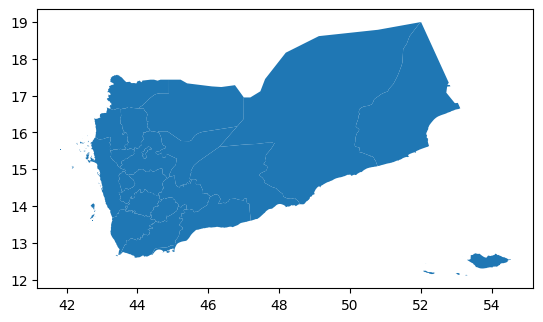

In [4]:
downloader = GADMDownloader(version="4.0")
country_name = "Yemen"
ad_level = 1
gadm1 = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gadm1.plot()

In [5]:
gadm1.to_file(join(data_dir, "YEM_GADM_adm1.shp"), driver="ESRI Shapefile")

## 2. NTL Data Cleaning

In [6]:
start = "2018-01-01"
end = "2023-05-01"

NTL statistics are extracted from the GEE dataset using the `ZonalStats` function from the [GEE Zonal](https://worldbank.github.io/GEE_Zonal/) package.

**Zonal Statistics** is a GIS method used to aggregate raster data (gridded datasets) into desired target areas (e.g. subnational boundaries), by making a statistical summary of the multiple values in each area, using a specific function (sum, max, mean, min, etc.).

The `ZonalStats` function is an implementation of this method using the Earth Engine API.

### Check for cloud cover

This first `ZonalStats` calculation uses the cloud-free-coverage band available in the NTL data to examine the quality of the data, and identify if there are months with no valid daily NTL observations to use in the monthly composite.  

Here, we are calculating the share of pixels where cloud-free coverage is greater than 0. If cloud-free coverage = 0, this means there is no valid data for that month. 

In [7]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('cf_cvg').filterDate(start, end)

# get coverage with valid observations greater than 0
def getGT0(image): 
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start'))

# get total number of observations (coverage greater or equal to 0)
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start'))

aoi = gee_helpers.gpd_to_gee(gadm1)

coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
df_gt0 = res.copy()

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
df_gte0 = res.copy()

# calculate percentage of valid observations
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col
df_pct.rename(rename_func, axis=1, inplace=True)
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_pct_re.reset_index(inplace=True)
df_pct_re.loc[:,"ym"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [8]:
plotnine.options.figure_size = (12, 12)

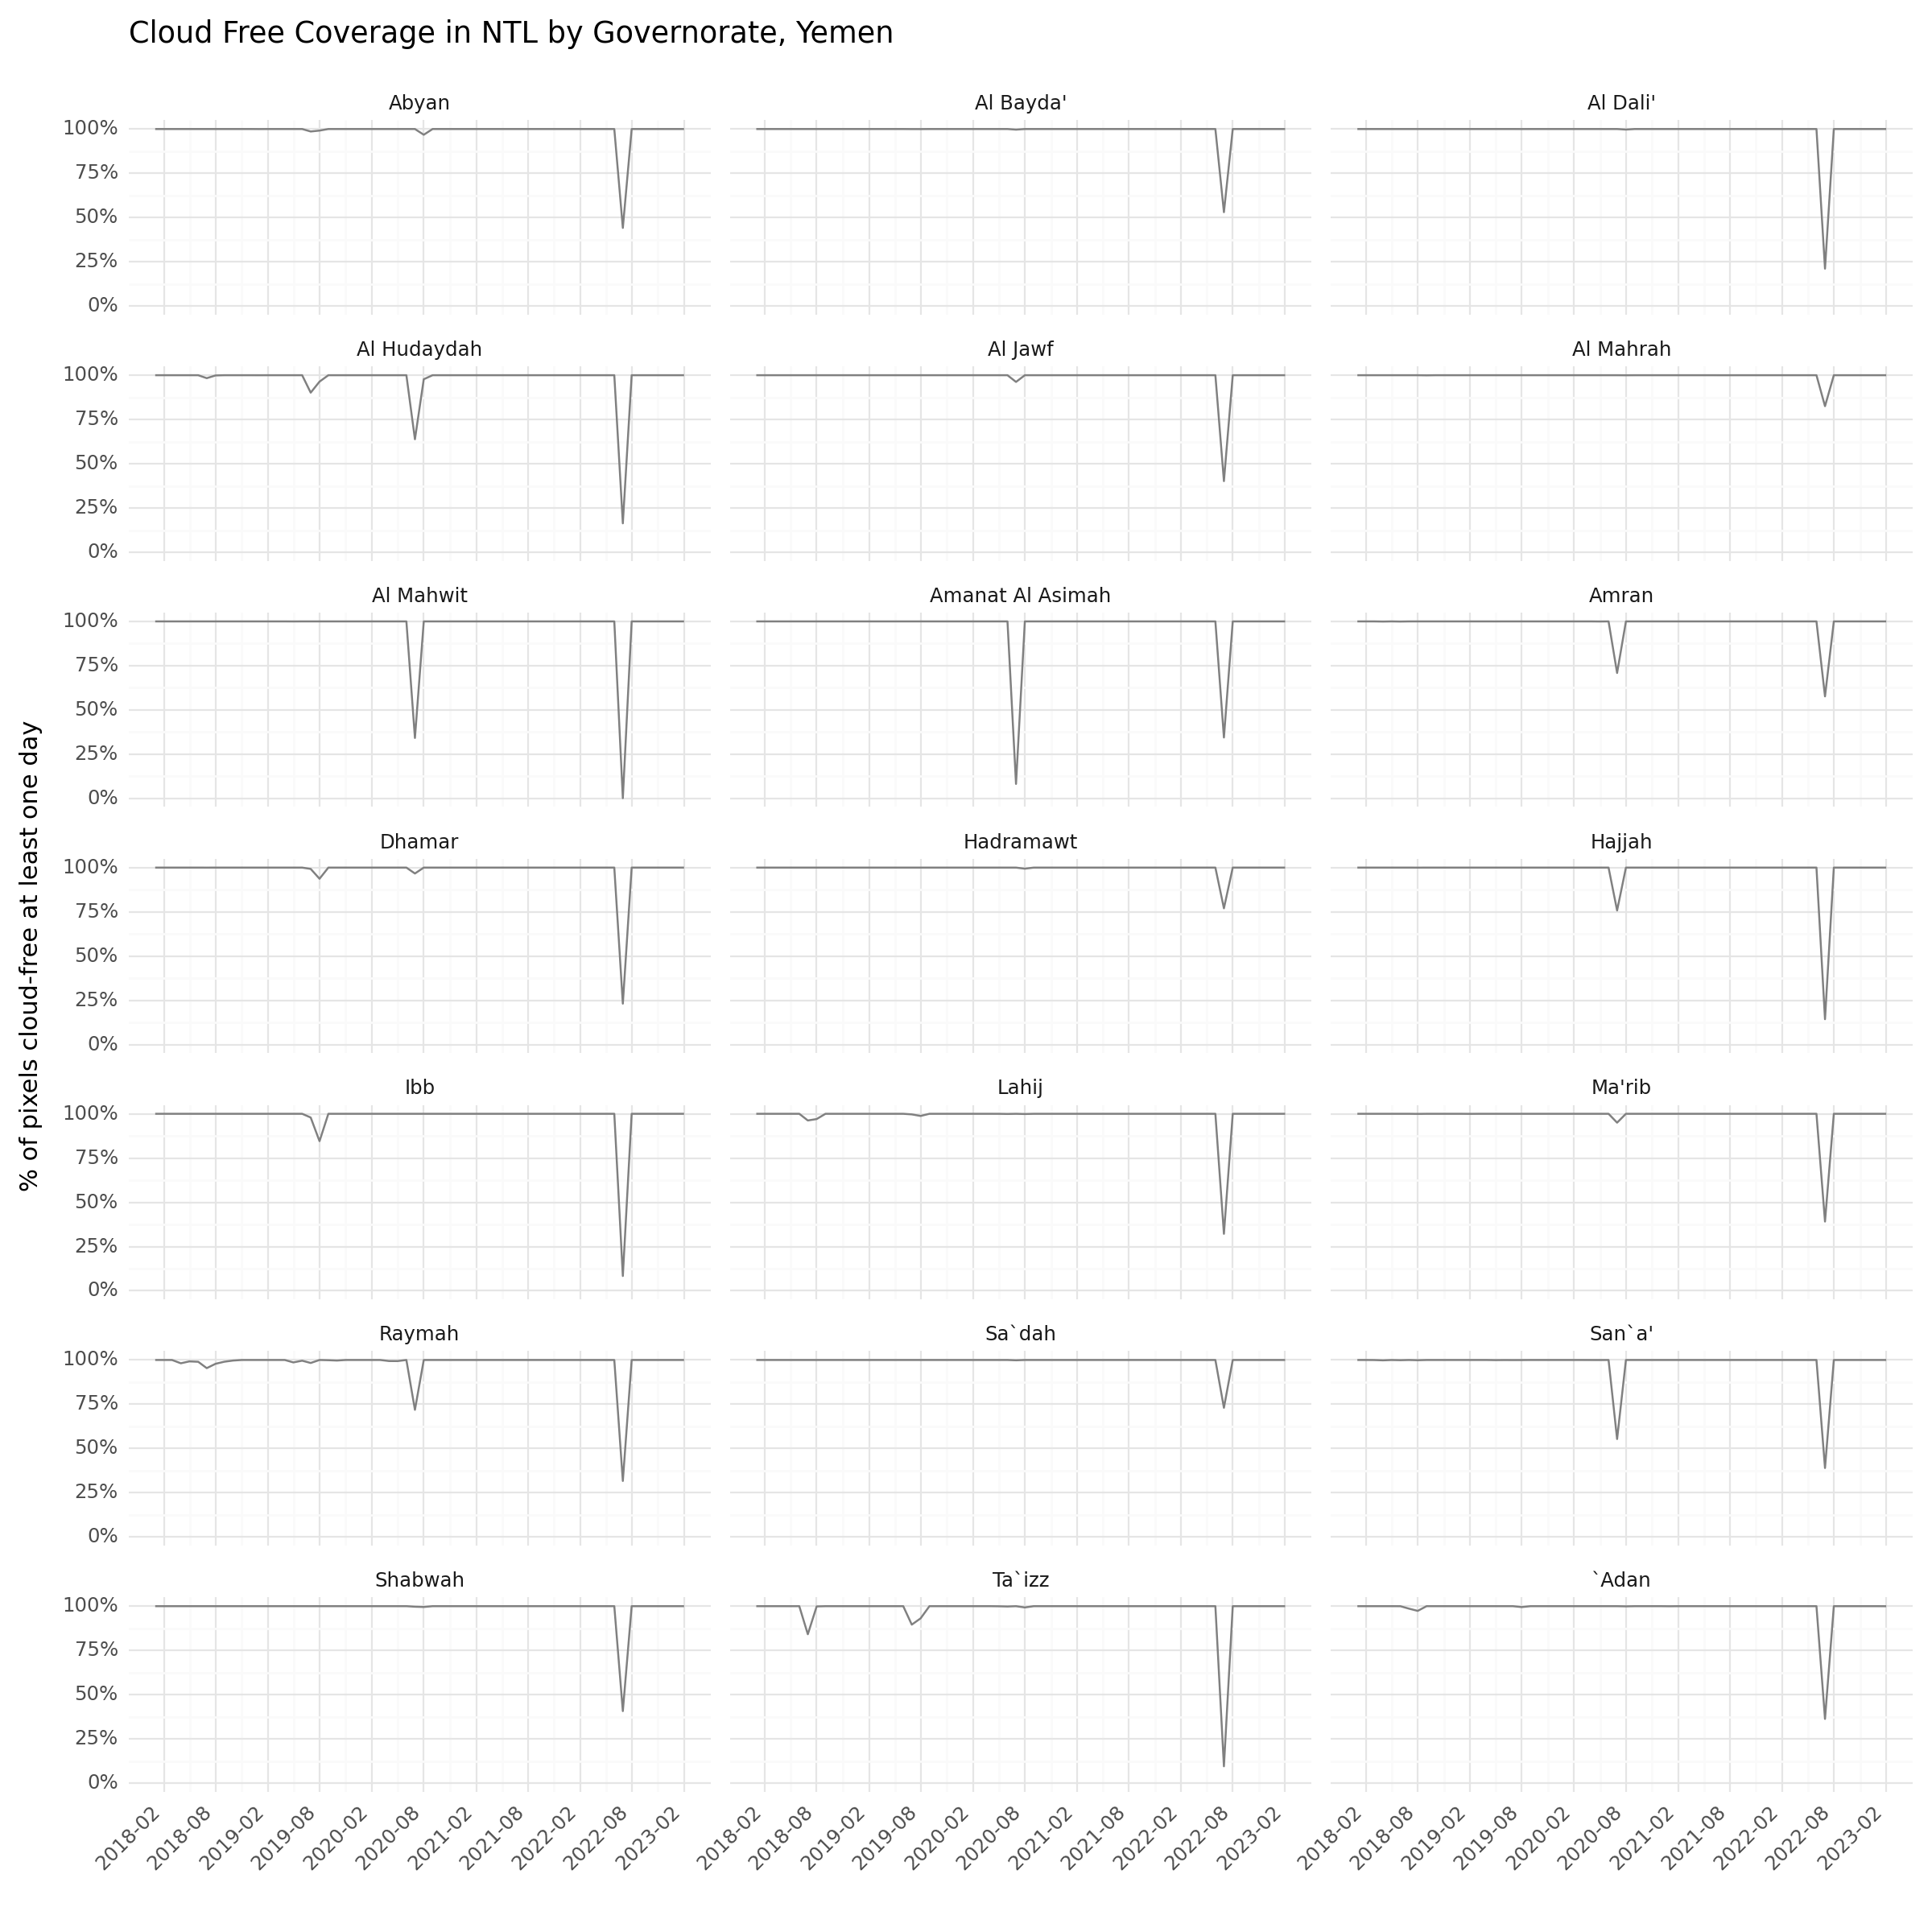

<Figure Size: (1200 x 1200)>

In [9]:
plot = (
ggplot(df_pct_re, aes(x="ym", y="pct", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + labs(
        x="", y="% of pixels cloud-free at least one day", title="Cloud Free Coverage in NTL by Governorate, Yemen",
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('6 months'), labels=date_format('%Y-%m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
plot

### Interpolate pixels with missing data due to clouds

The following function applies a smoothing algorithm to the data using a moving-window (3 months before and after) linear regression pixel-by-pixel. For pixels with no valid observations, it replaces the missing data with the interpotated values.

In [10]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smoother function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [11]:
## Reference to the radiance band from the VIIRS monthly composite
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('avg_rad').filterDate(start, end) # VCMSLCFG

## Reference to the VIIRS monthly composite with both cloud cover and radiance
viirs_copy = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate(start, end)

# Reference to the VIIRS radiance data, with gaps filled with interpolated values
viirs_interpolated = smoothenViirs(viirs_copy, 3)

### Mask Flares

Merge flare file provided by Ali with latest from DDH.

In [15]:
flares = gpd.read_file(join(data_dir, "flaring", "Flaring Shapefiles.shp"))

In [16]:
flares_2021 = pd.read_csv(join(data_dir, "flaring", "flares_2021.csv"))
flares_2021.loc[:, "geometry"] = flares_2021.apply(lambda x: Point(x["Longitude"], x["Latitude"]), axis=1)
flares_2021 = gpd.GeoDataFrame(flares_2021, geometry="geometry", crs="EPSG:4326")
flares_2021.loc[:, "year"] = 2021

flares = pd.concat([flares, flares_2021])
flares.loc[:, "year"] = flares.loc[:, "year"].astype(int)

In [17]:
flares = flares.to_crs("EPSG:32638")
flares.loc[:, "geometry"] = flares.geometry.buffer(5000)
flares = flares.to_crs("EPSG:4326")
flares.loc[:, "mask"] = 0

### Run zonal stats on NTL

Calculate sum of lights over admin-1 areas, mask flares

In [18]:
res_all = []

for year in range(2018, 2024, 1):
    if year >= 2021:
        flare_year = 2021
    else:
        flare_year = year
    
    flares_sel = flares.loc[flares.year == flare_year, :].copy()
    flares_ee = gdf_to_ee(flares_sel)
    flares_img = flares_ee.reduceToImage(properties=["mask"], reducer=ee.Reducer.first())
    flares_mask = flares_img.unmask(1)

    zs = ZonalStats(
        collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
        target_features = aoi,
        statistic_type= 'sum',
        scale = 500,
        frequency = 'original',
        ee_dataset = viirs_interpolated,
        mask = flares_mask,
        start_year = year,
        end_year = year
    )
    res = zs.runZonalStats()
    df_ee_int = res.copy()

    def rename_func(col):
        if "avg_rad" in col:
            p = col.split("_")
            if len(p)>1:
                new_name = "rad"+"__"+p[0]
                return(new_name)
            else:
                return col
        else:
            return col
    df_ee_int.rename(rename_func, axis=1, inplace=True)
    df_ee_int = pd.wide_to_long(
        df_ee_int,
        stubnames = ['rad'],
        i = 'NAME_1',
        j = 'date',
        sep = "__"
    )
    df_ee_int.reset_index(inplace=True)
    df_ee_int.loc[:,"ym"] = pd.to_datetime(df_ee_int.date, format="%Y%m%d")

    res_all.append(df_ee_int)

In [19]:
df_masked = pd.concat(res_all)

In [20]:
df_masked.rename(columns={"rad":"rad_masked"}, inplace=True)

### Run zonal stats on NTL over flares

Calculate sum of lights over admin-1 areas, only on flares

In [21]:
flares.loc[:, "mask"] = 1

In [22]:
res_all = []

for year in range(2018, 2024, 1):
    if year >= 2021:
        flare_year = 2021
    else:
        flare_year = year
    
    flares_sel = flares.loc[flares.year == flare_year, :].copy()
    flares_ee = gdf_to_ee(flares_sel)
    flares_img = flares_ee.reduceToImage(properties=["mask"], reducer=ee.Reducer.first())
    flares_mask = flares_img.unmask(0)

    zs = ZonalStats(
        collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
        target_features = aoi,
        statistic_type= 'sum',
        scale = 500,
        frequency = 'original',
        ee_dataset = viirs_interpolated,
        mask = flares_mask,
        start_year = year,
        end_year = year
    )
    res = zs.runZonalStats()
    df_ee_int = res.copy()

    def rename_func(col):
        if "avg_rad" in col:
            p = col.split("_")
            if len(p)>1:
                new_name = "rad"+"__"+p[0]
                return(new_name)
            else:
                return col
        else:
            return col
    df_ee_int.rename(rename_func, axis=1, inplace=True)
    df_ee_int = pd.wide_to_long(
        df_ee_int,
        stubnames = ['rad'],
        i = 'NAME_1',
        j = 'date',
        sep = "__"
    )
    df_ee_int.reset_index(inplace=True)
    df_ee_int.loc[:,"ym"] = pd.to_datetime(df_ee_int.date, format="%Y%m%d")

    res_all.append(df_ee_int)

In [23]:
df_flares = pd.concat(res_all)

In [24]:
df_flares.rename(columns={"rad":"rad_flares"}, inplace=True)

### Merge both time series

Merge two time series (sum of lights from masked and flares).

In [26]:
df = df_masked.merge(df_flares[['NAME_1', 'ym', 'rad_flares']], on=['NAME_1', 'ym'], how='left', validate='1:1')

In [27]:
df.loc[:, "month"] = df.ym.dt.month
df.loc[:, "year"] = df.ym.dt.year

In [33]:
df.tail(2)

,NAME_1,date,VARNAME_1,ID_1,ISO_1,CC_1,HASC_1,ENGTYPE_1,TYPE_1,COUNTRY,NL_NAME_1,ID_0,rad_masked,ym,rad_flares,month,year
1300,Shabwah,20230201,Shabwa|Shibwah|Ataq,YEM.20_1,,21,YE.SH,Governorate,Muhafazah,Yemen,شبوة,YEM,41678.614490,2023-02-01,19474.004735,2,2023
1301,Ta`izz,20230201,Taez|Taiz|Taizz,YEM.21_1,,15,YE.TA,Governorate,Muhafazah,Yemen,تعز,YEM,13494.921283,2023-02-01,0.000000,2,2023


In [34]:
df.loc[:, df.columns!='rad'].to_csv(join(output_dir, 'adm1_viirs_raw_data_flares.csv'), index=False)

### Plot NTL

In [35]:
df_copy = df.copy()

In [36]:
df_copy = df_copy.melt(id_vars=['NAME_1', 'ym', 'month', 'year'], value_vars=['rad_masked', 'rad_flares'], var_name='type', value_name='rad')

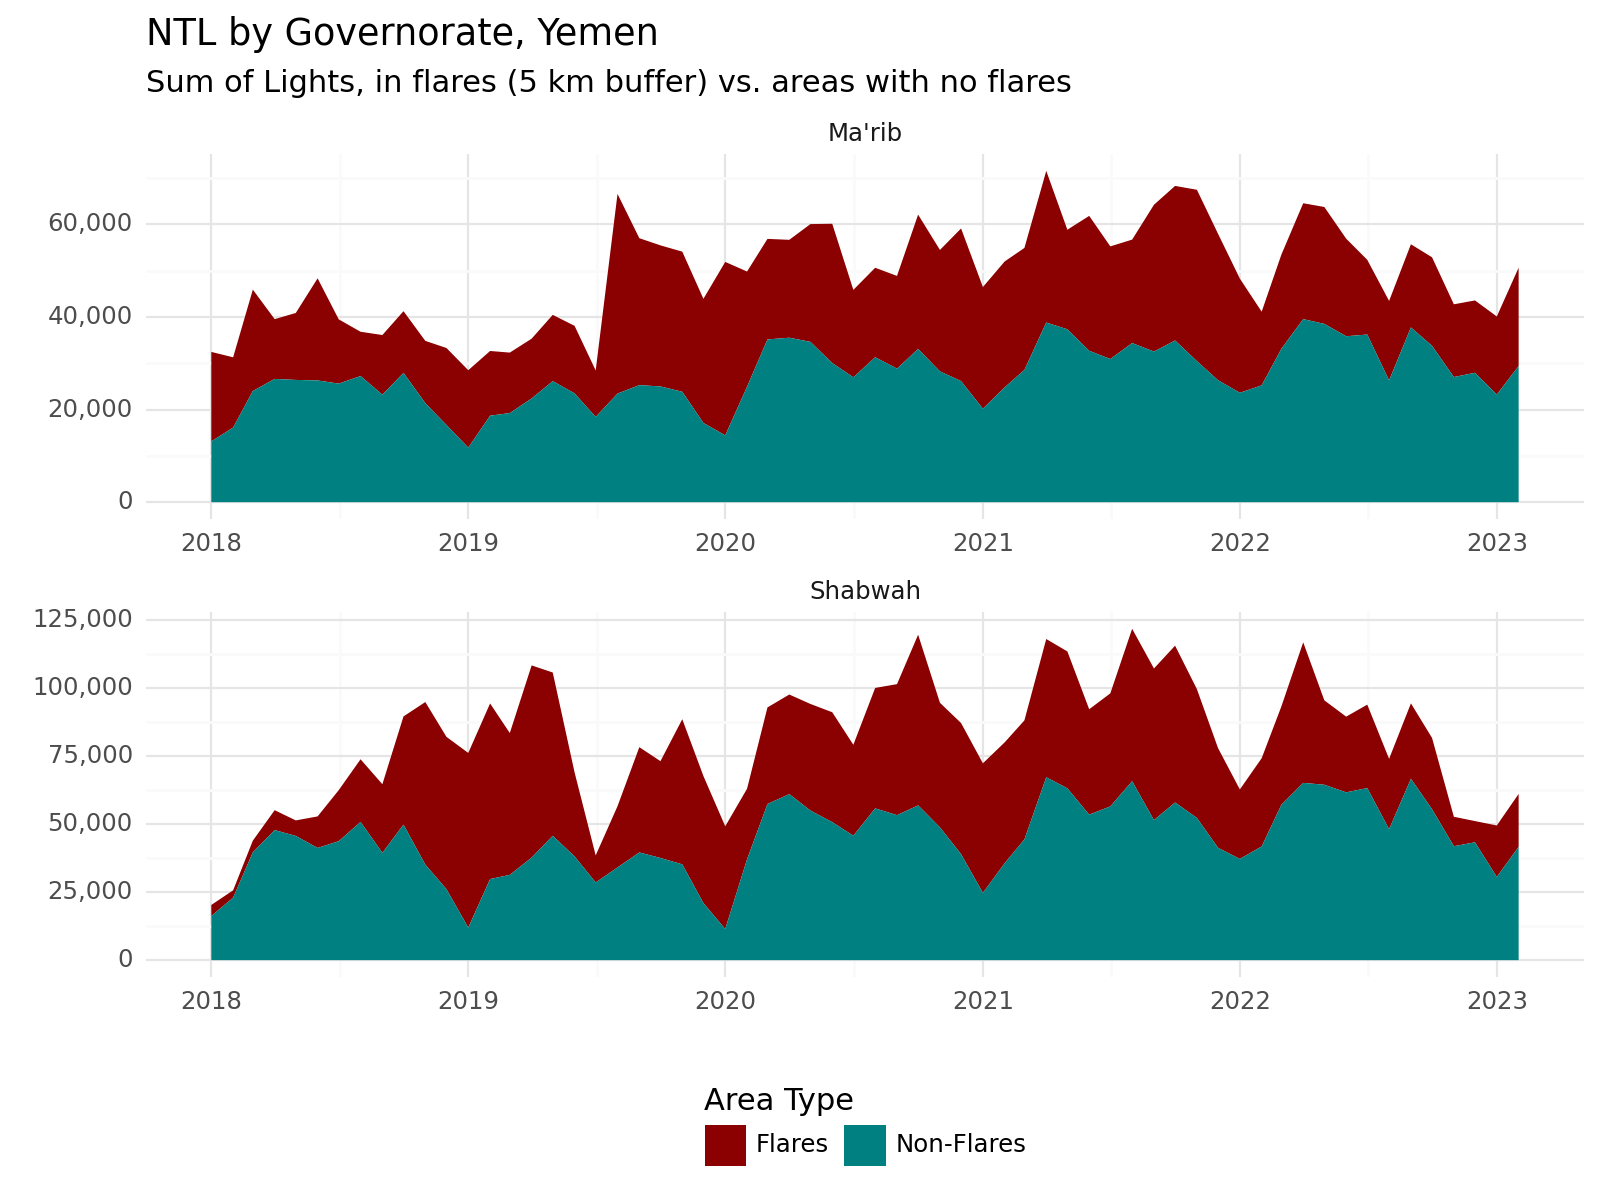

<Figure Size: (800 x 600)>

In [47]:
p4 = (
ggplot(df_copy.loc[df_copy.NAME_1.isin(["Ma'rib", "Shabwah"])], aes(x="ym", y="rad", group="type", fill="type")) #
    + geom_area(alpha=1)
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights, in flares (5 km buffer) vs. areas with no flares",
        fill="Area Type"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom', figure_size=(8, 6))
    + facet_wrap("~NAME_1", scales = "free", ncol=1)
    + scale_fill_manual(labels=['Flares', "Non-Flares"], values=['darkred','teal'])
)
p4
# p4.save(filename=join(output_dir, 'adm1-lights-flares.jpeg'), dpi=300)

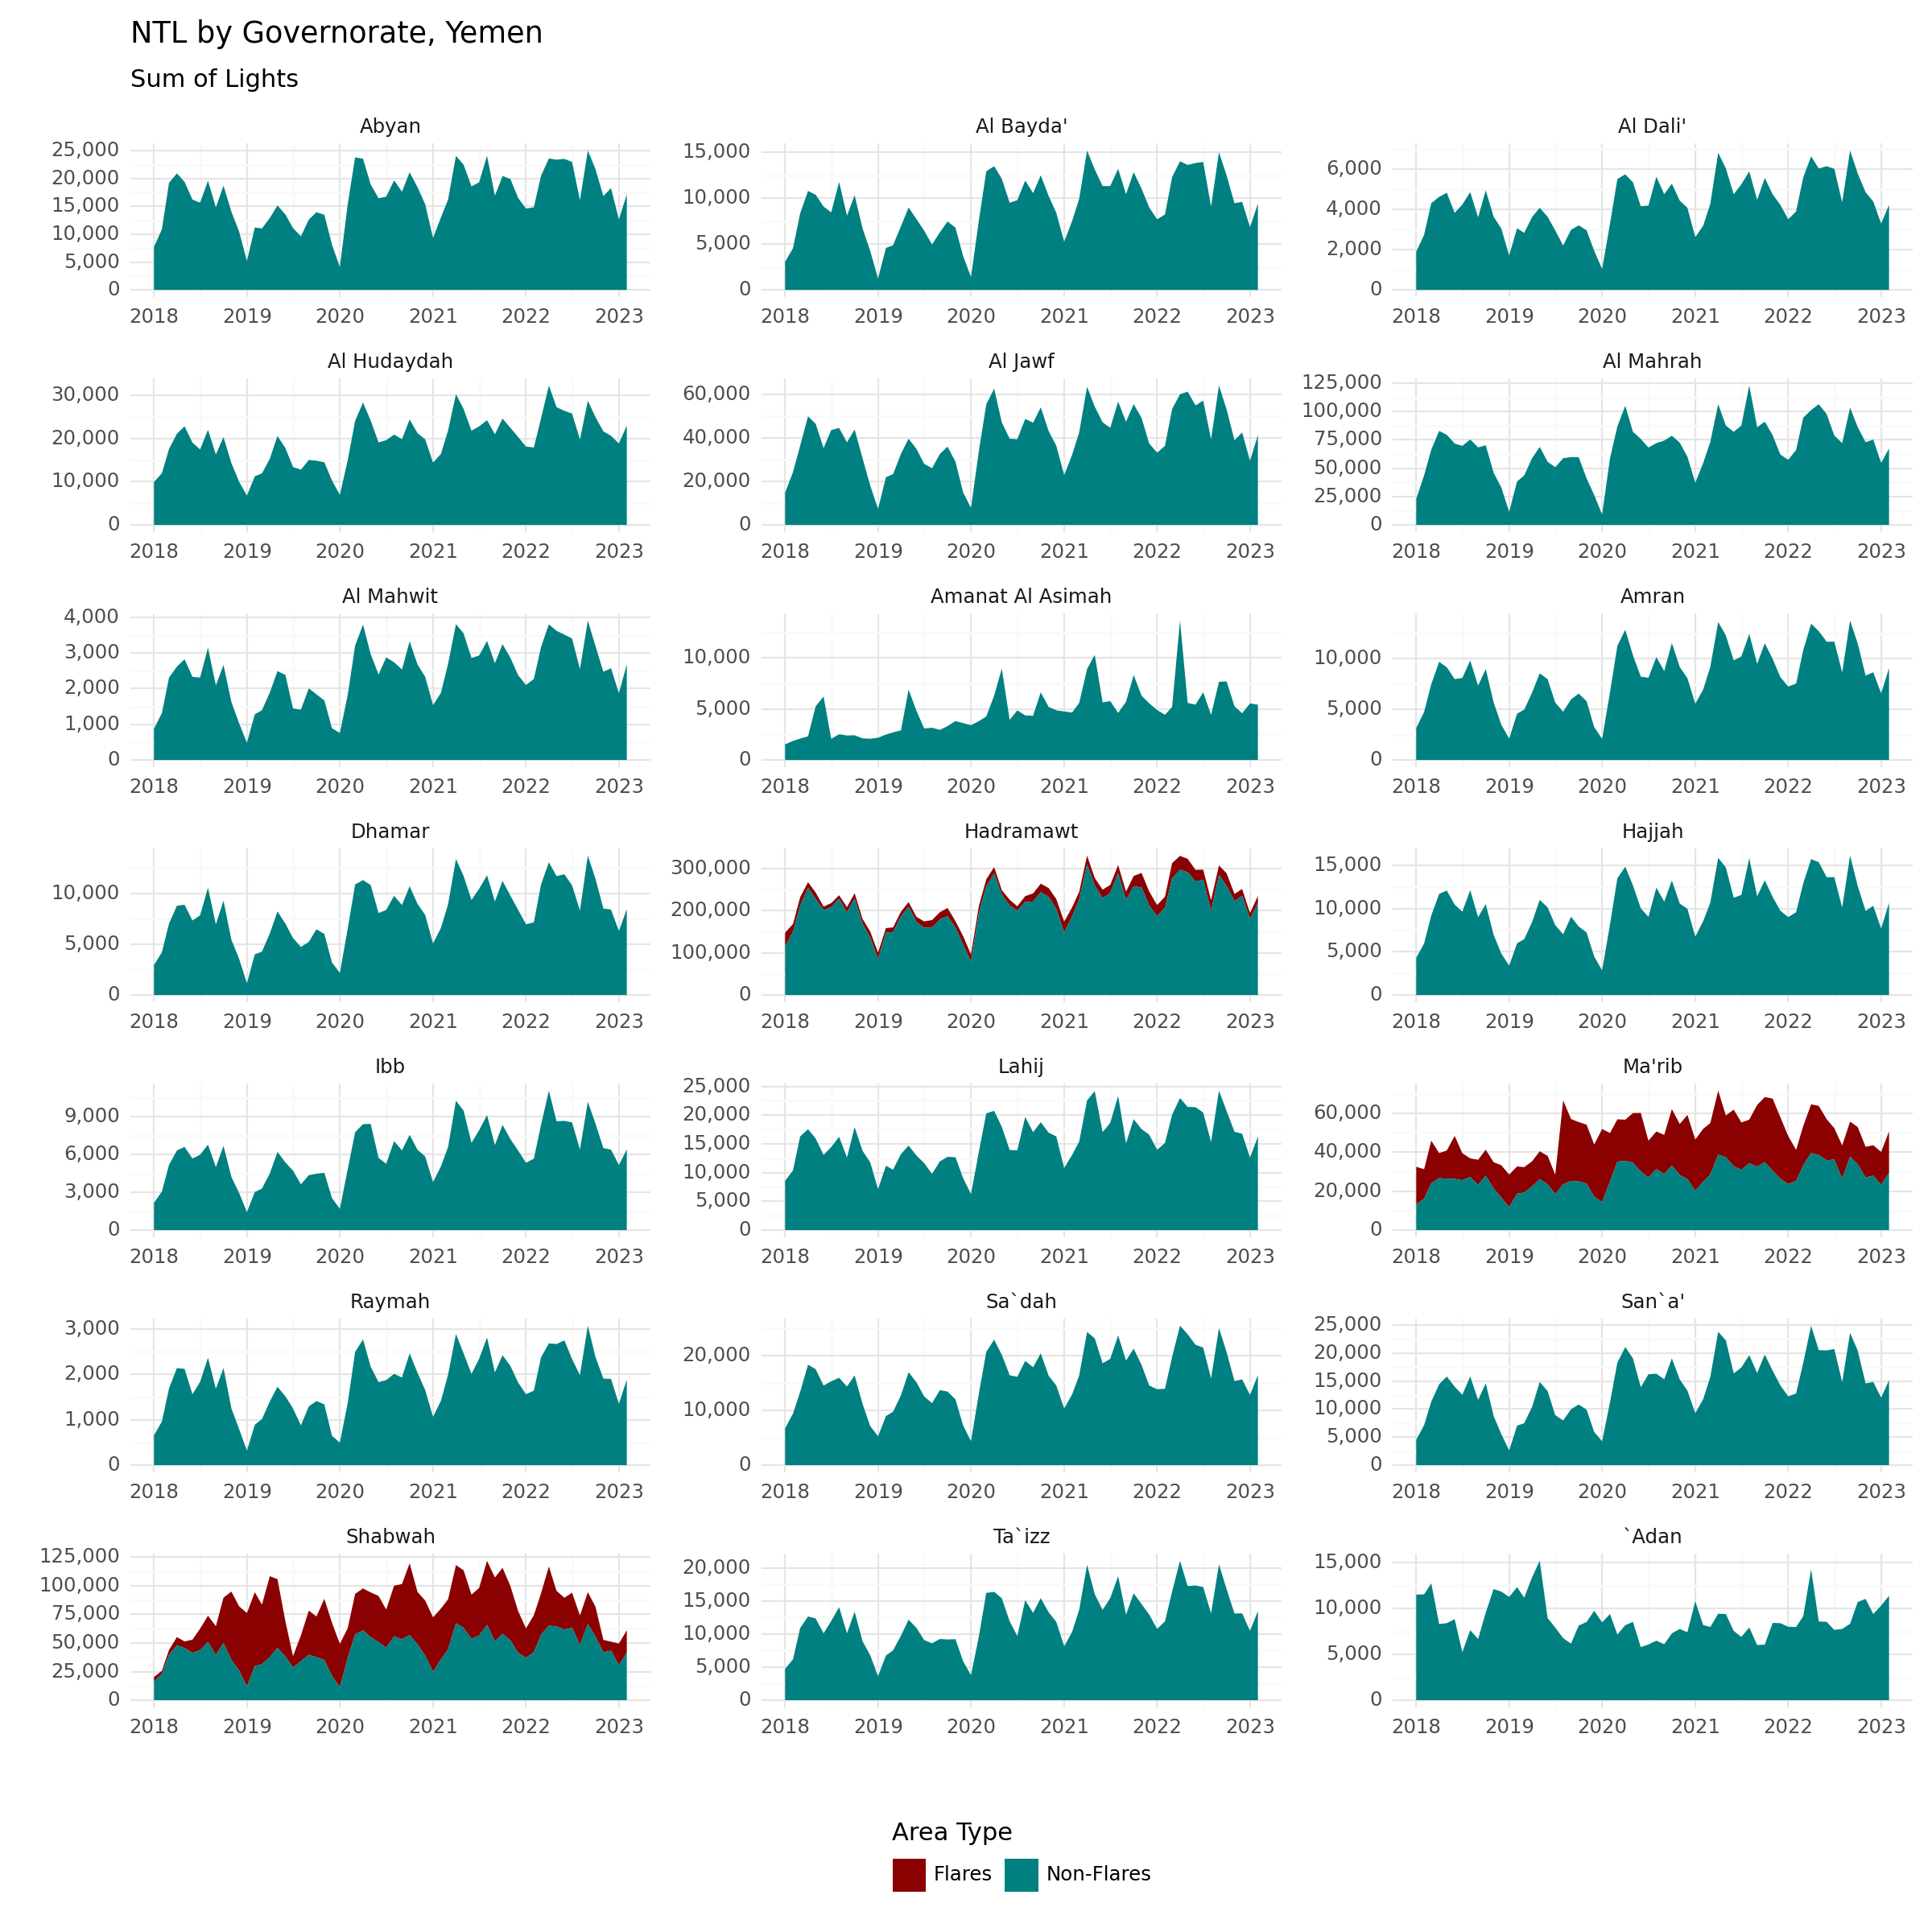

<Figure Size: (1200 x 1200)>

In [49]:
p4 = (
ggplot(df_copy, aes(x="ym", y="rad", group="type", fill="type")) #
    + geom_area(alpha=1)
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights",
        fill="Area Type"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
    + scale_fill_manual(labels=['Flares', "Non-Flares"], values=['darkred','teal'])
)
p4
# p4.save(filename=join(output_dir, 'adm1-lights-interpolation.jpeg'), dpi=300)

## 3. NTL difference from baseline
### Calculate reference values

Calculate historical monthly averages.  

Define reference period as previous years (2018-2021), or just 2021. 

In [50]:
df.rename(columns={"rad_masked":"rad_int"}, inplace=True)

In [51]:
def calculate_ref(period):
    if period==2021:
        df_ref = df.loc[df.year==2021,:].copy()
    else:
        df_ref = df.loc[df.year<2022,:].copy()
    
    df_ref = df_ref.groupby(["NAME_1", "month"])[['rad_int']].mean().reset_index()
    df_ref.rename(columns={"rad_int":"rad_int_ref"}, inplace=True)

    df_filt = df.merge(df_ref, on=["NAME_1", "month"], how="left", validate="m:1")
    df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
    df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
    df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
    df_filt.loc[:, "direction"] = ""
    df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
    df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"

    return df_filt

In [52]:
df_historical_baseline = calculate_ref('historical')
df_2021_baseline = calculate_ref(2021)

### Graphs

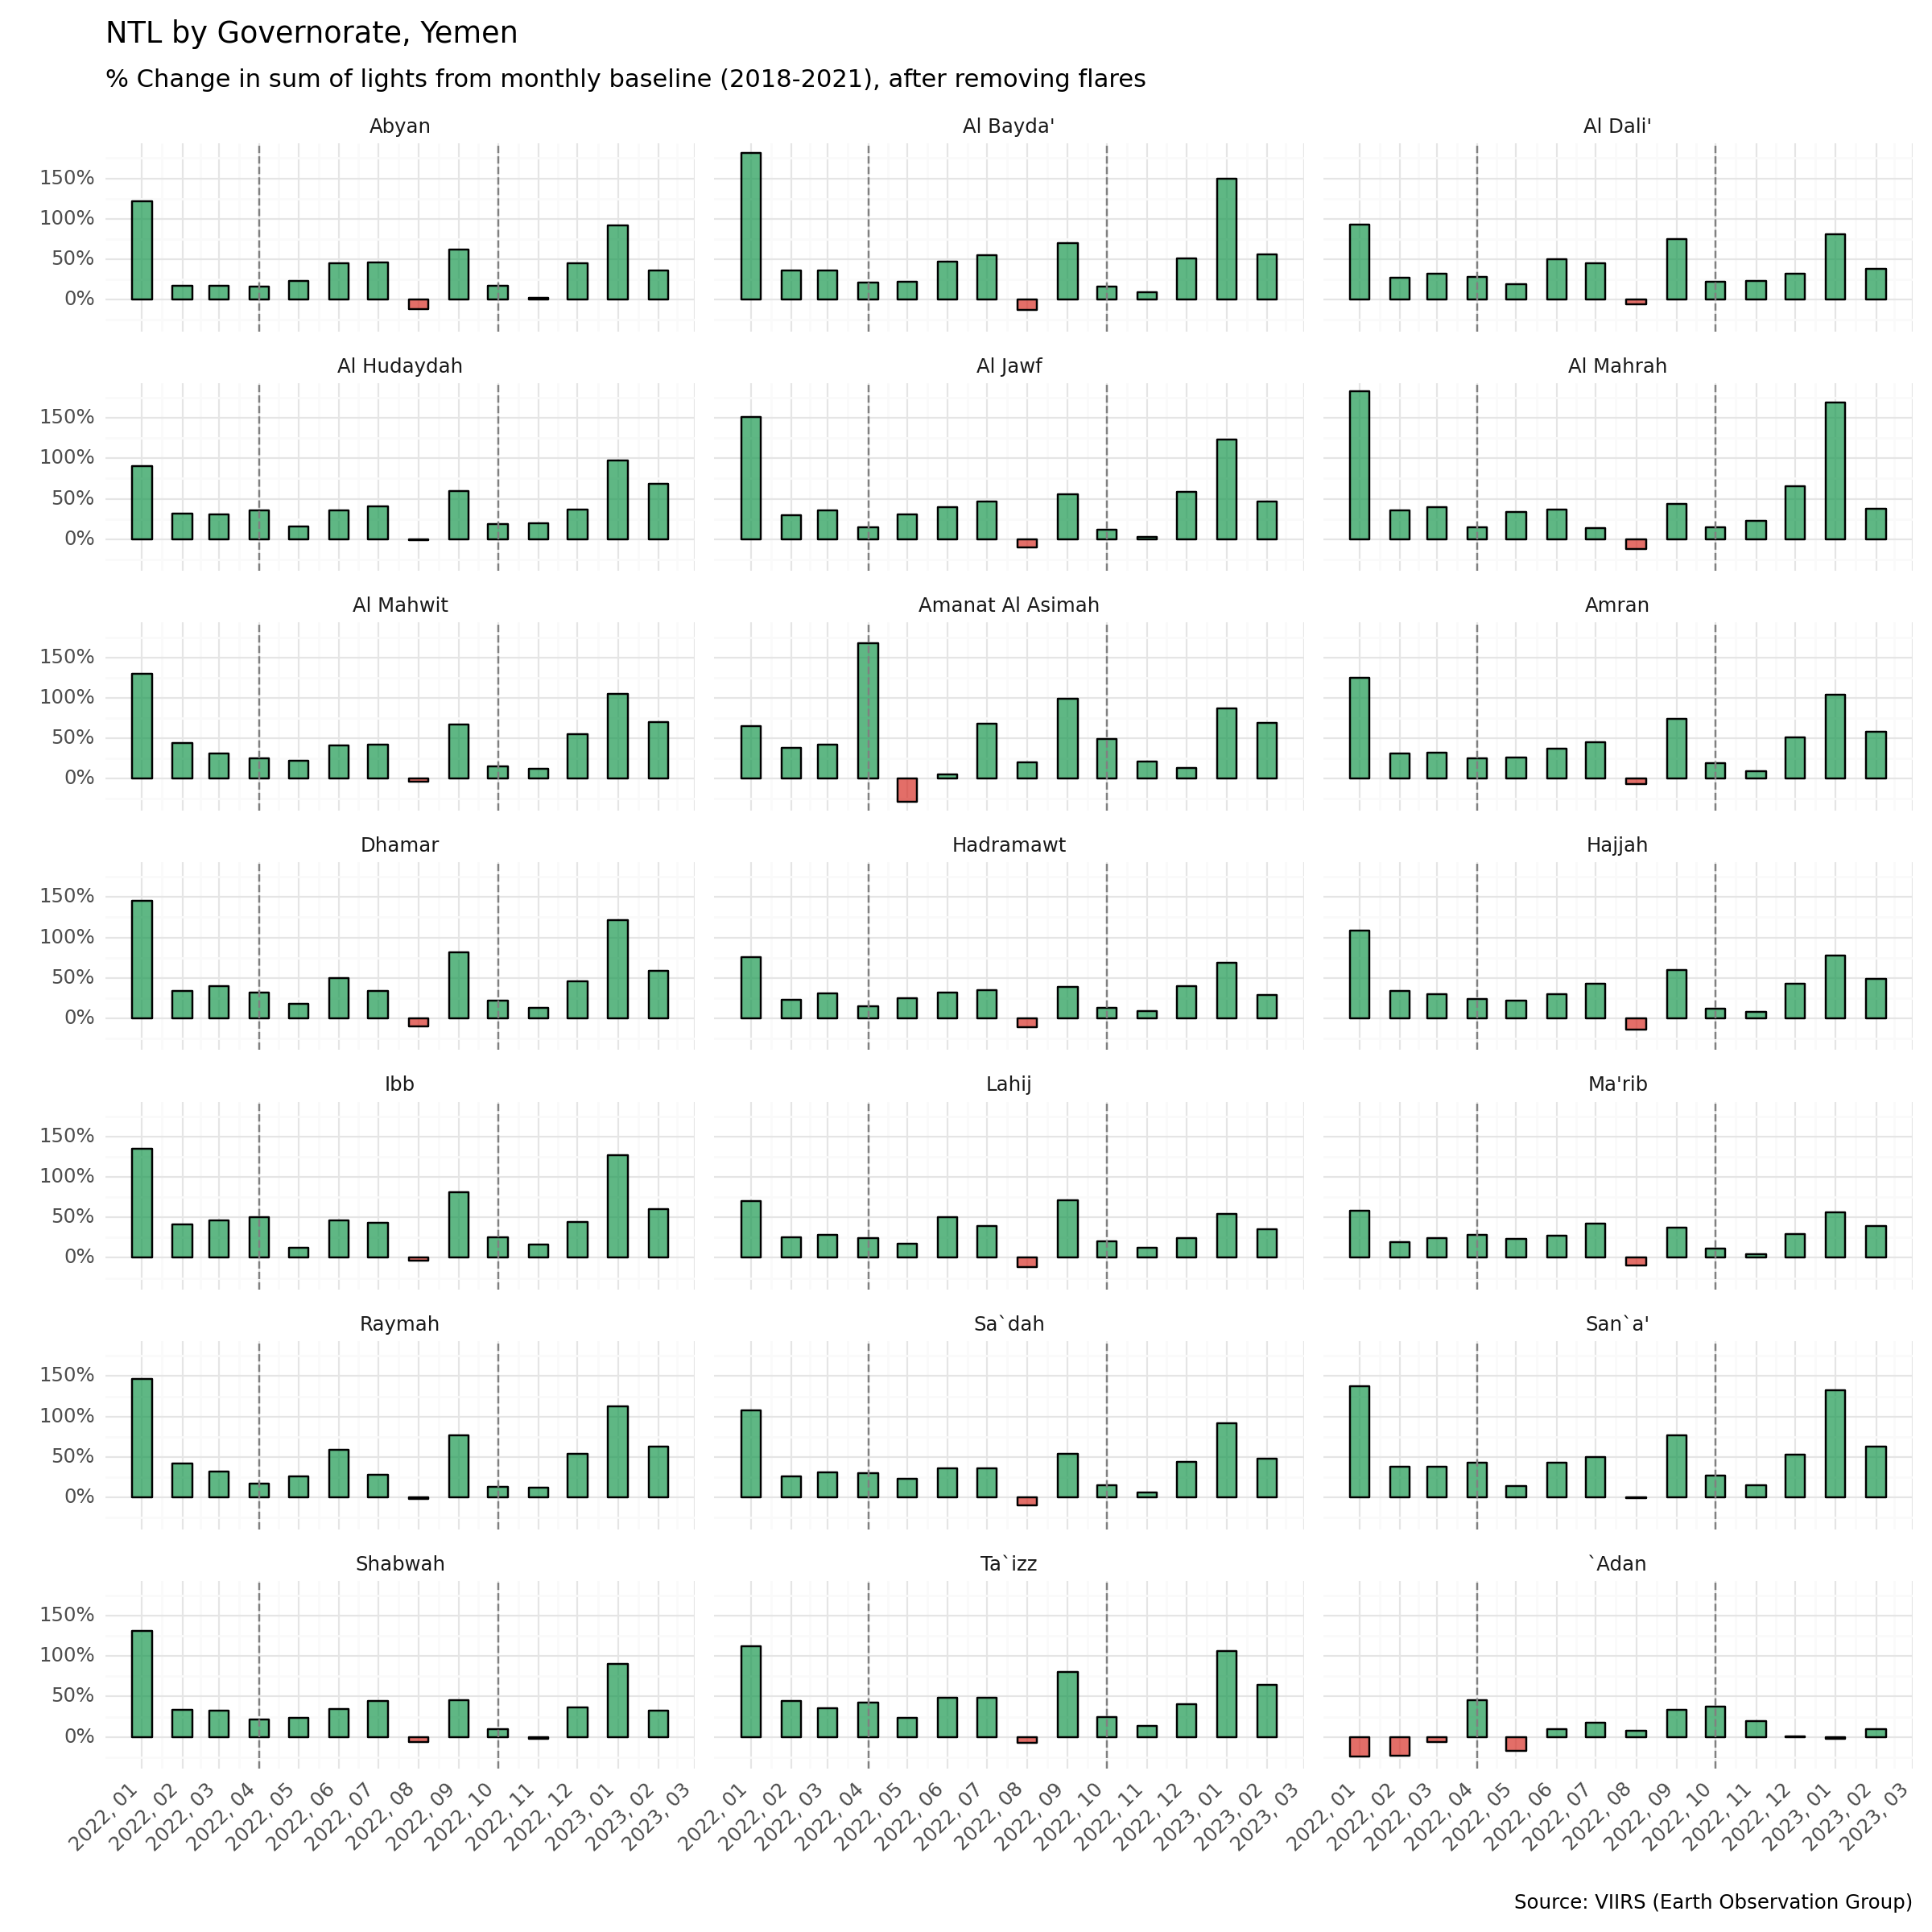

<Figure Size: (1200 x 1200)>

In [53]:
p1 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from monthly baseline (2018-2021), after removing flares",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 12))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
)
p1
# p1.save(filename=join(output_dir, 'adm1-pct-change-historical-masked.jpeg'), dpi=300)

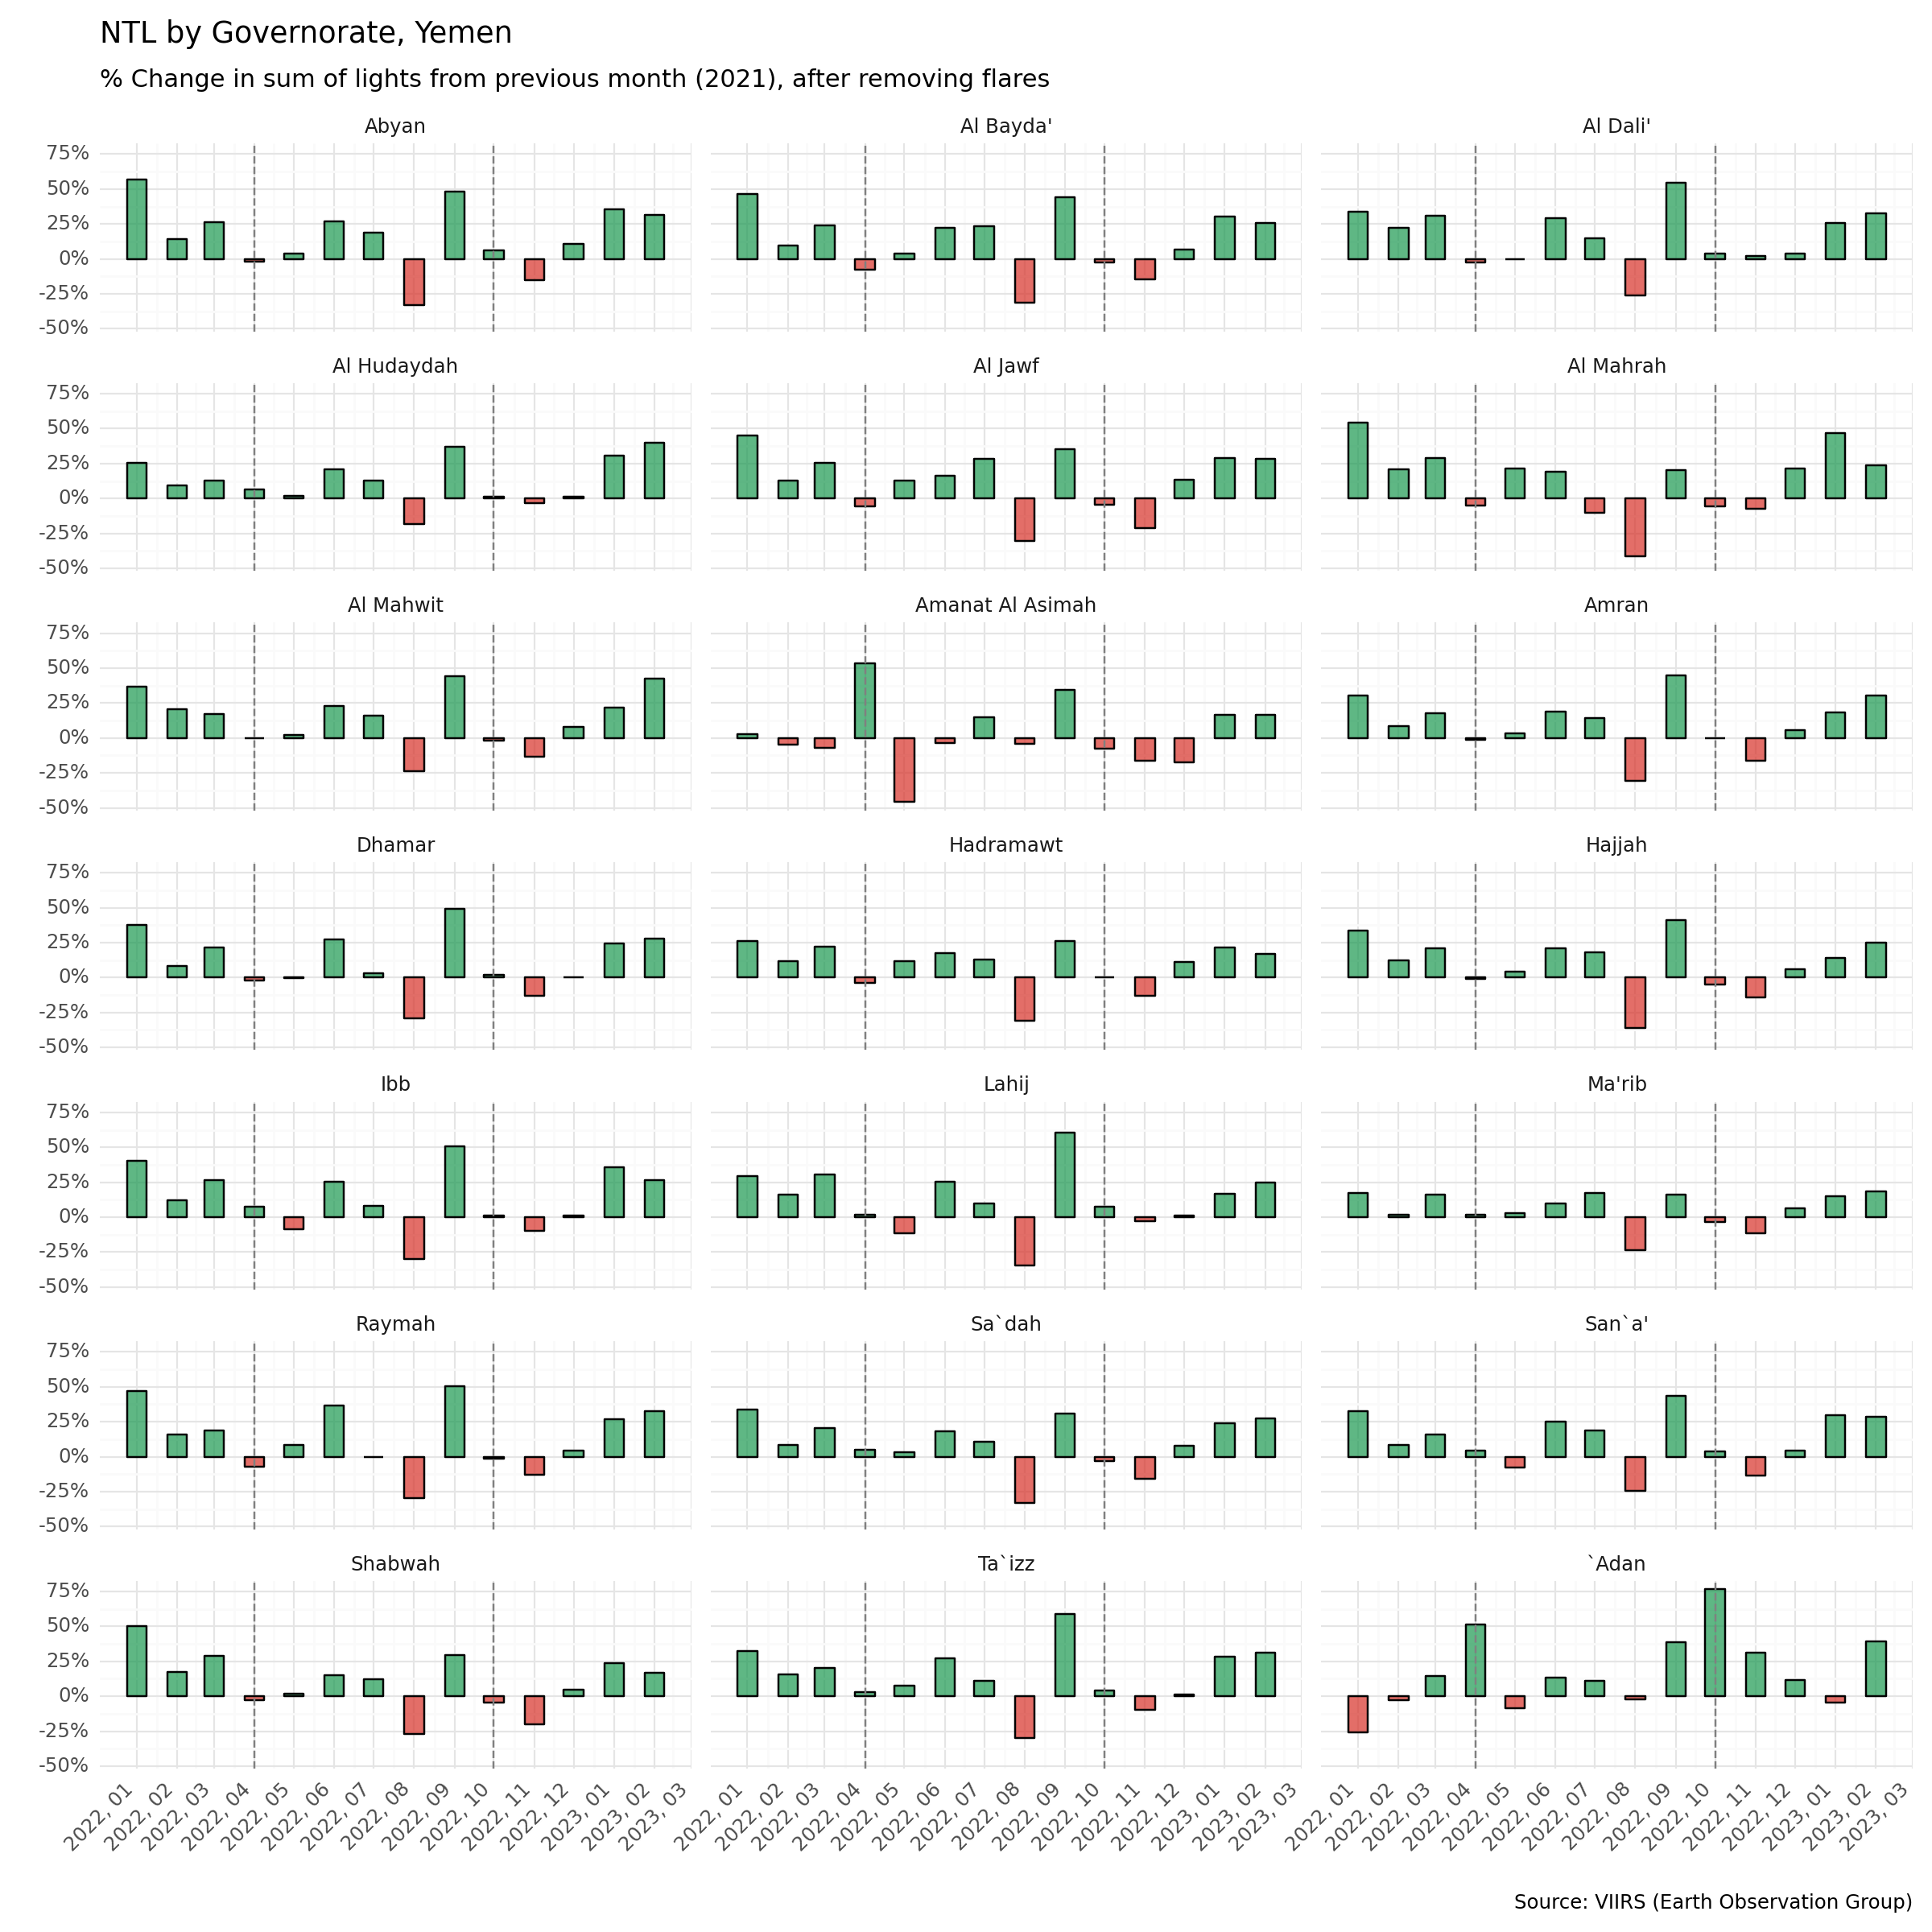

<Figure Size: (1200 x 1200)>

In [54]:
p2 = (
ggplot(df_2021_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from previous month (2021), after removing flares",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
)
p2
# p2.save(filename=join(output_dir, 'adm1-pct-change-2021-masked.jpeg'), dpi=300)

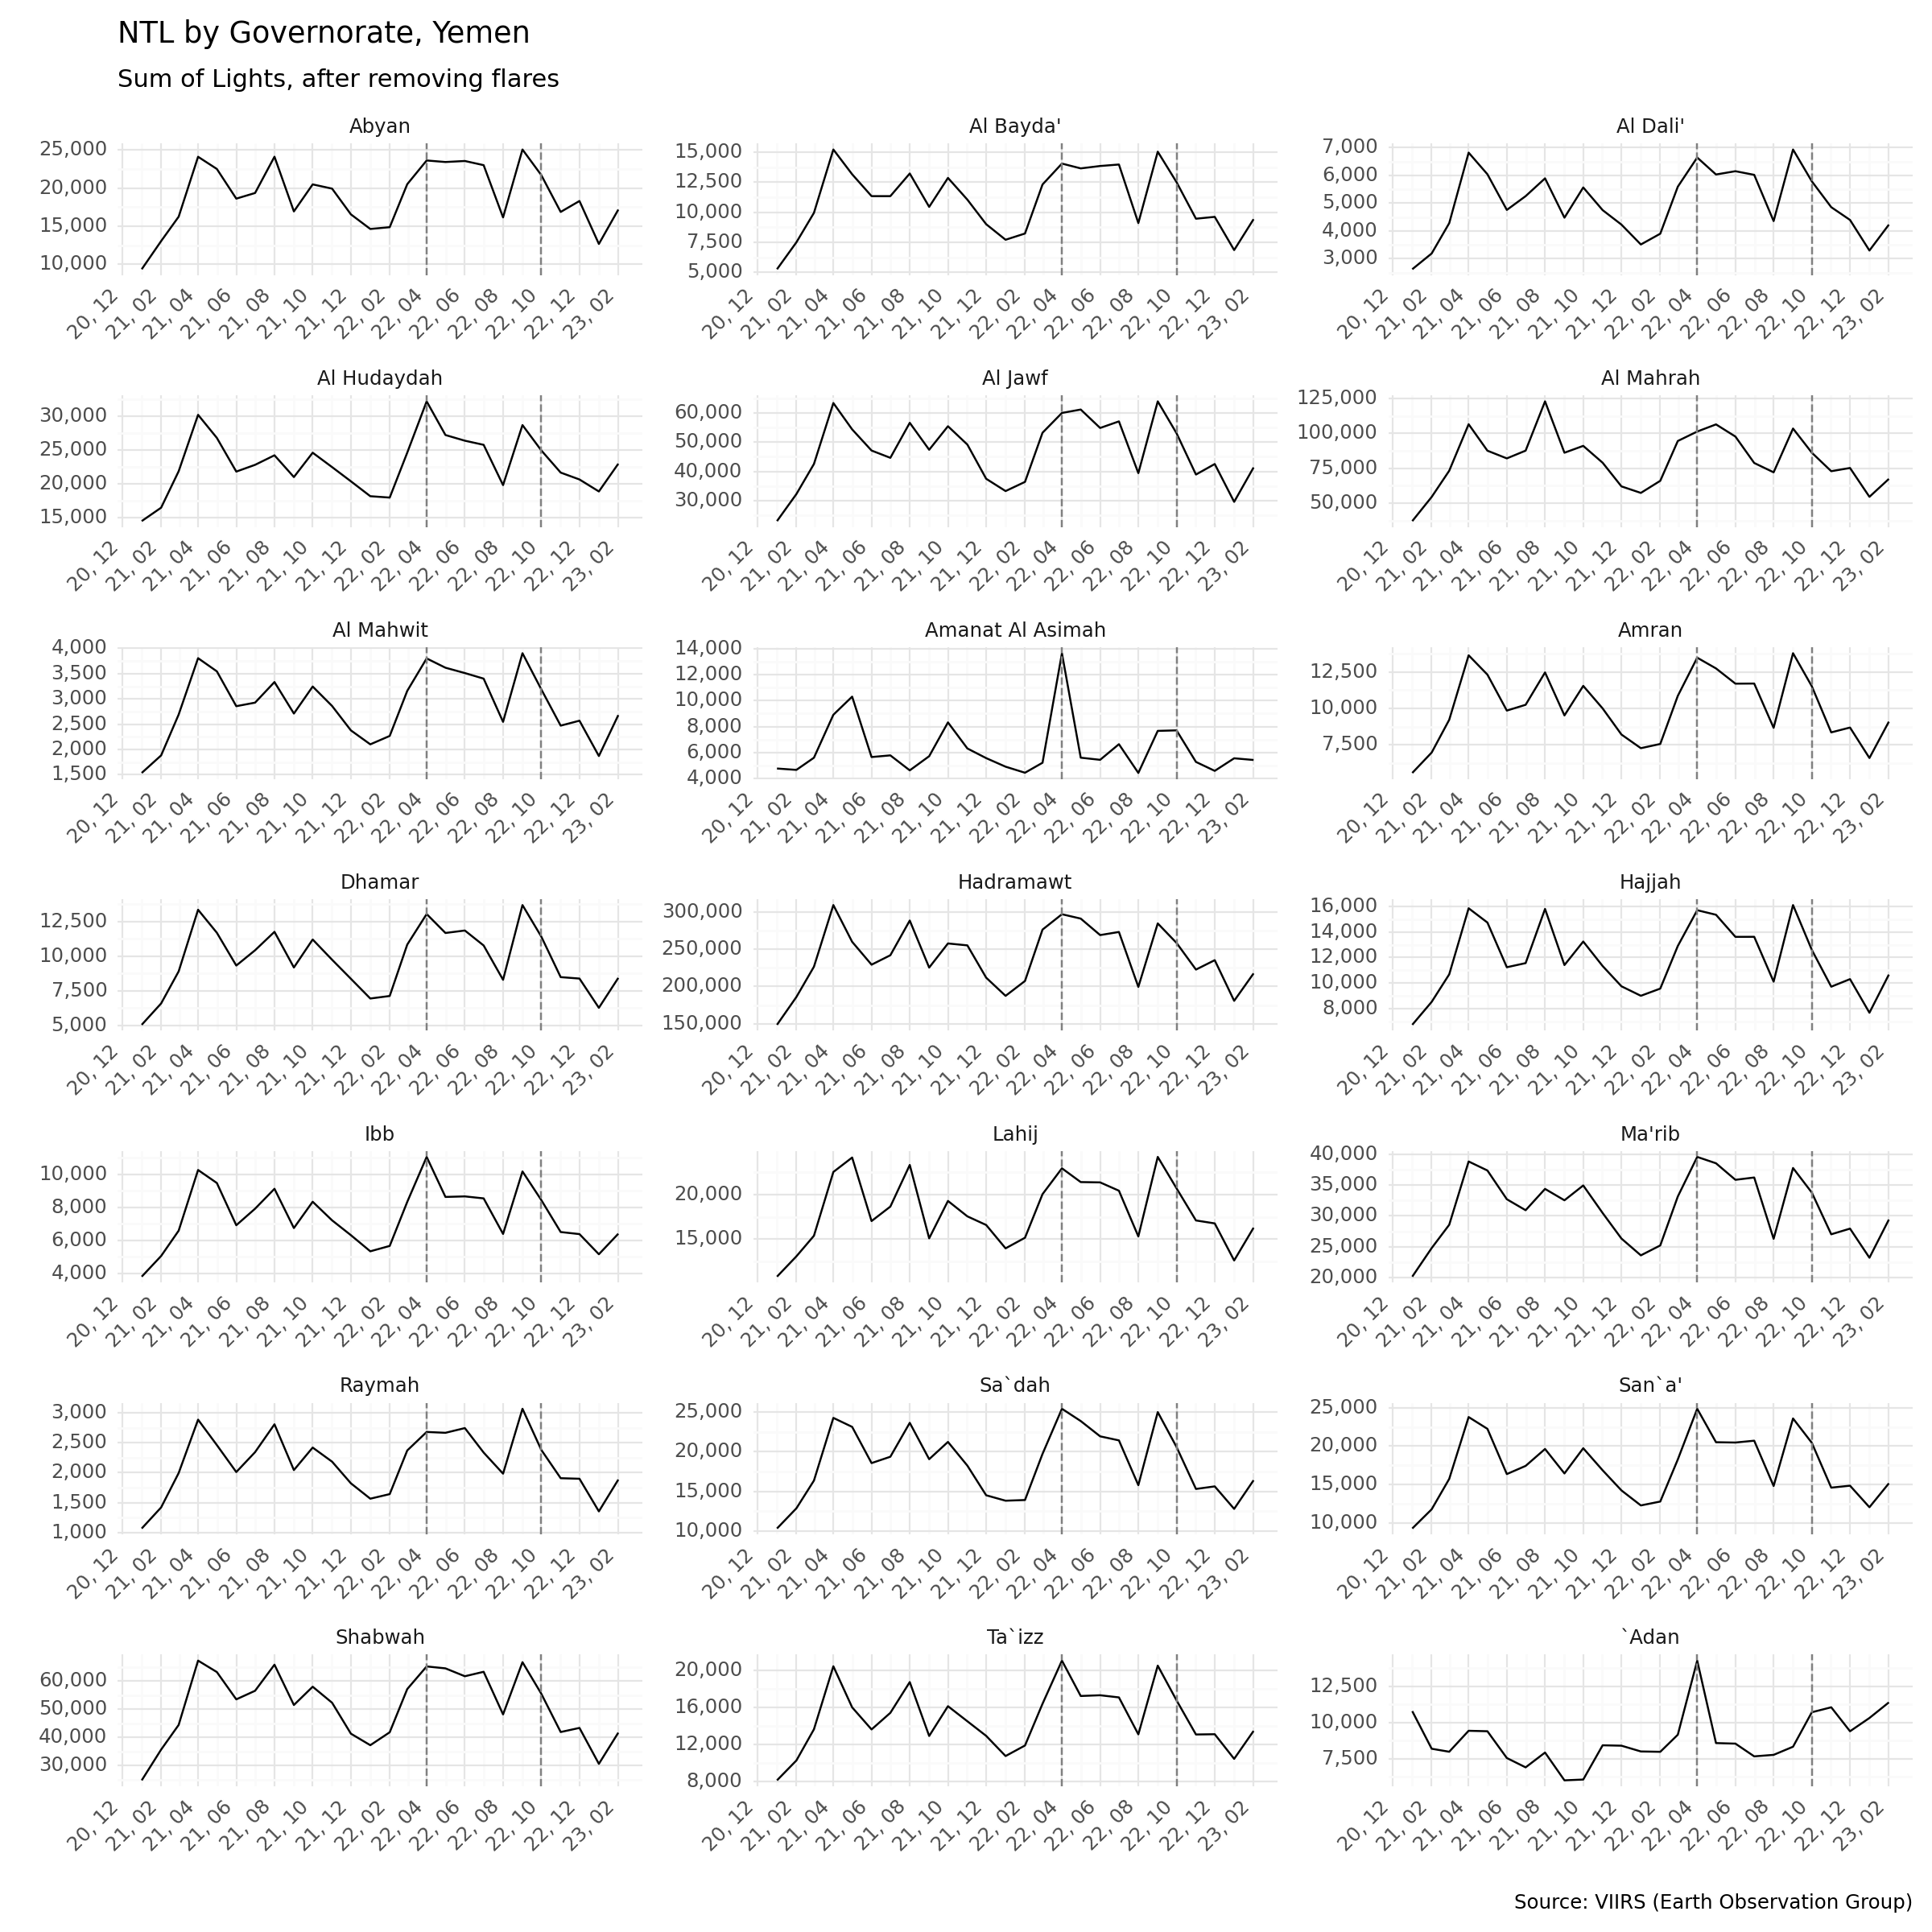

<Figure Size: (1200 x 1200)>

In [56]:
p3 = (
ggplot(df.loc[df.year>=2021], aes(x="ym", y="rad_int", group="NAME_1")) #
    + geom_line(alpha=1)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights, after removing flares",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y, %m'))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
p3
# p3.save(filename=join(output_dir, 'adm1-lights-masked.jpeg'), dpi=300)

In [57]:
# df_historical_baseline.drop(['rad', 'rad_ref'], axis=1, inplace=True)

In [67]:
df_historical_baseline.to_csv(join(output_dir, 'adm1_viirs_pct_change_masked.csv'), index=False)